# SpectralFPM Simulation

Neerja Aggarwal

Oct 23rd, 2024

Simulate the measurement & attempt reconstruction for a spectral object. 


In [1]:
import fpm_helper as fpm
import matplotlib.pyplot as plt
import numpy as np
import torch
# plt.style.use('dark_background')

In [2]:
device = fpm.use_gpu(2)

cuda:2


# setup the fpm system

In [3]:
mag = 4 # 4x 
pix_size_camera = 4 #  micron"
wv_start = 400e-3 # micron
wv_end = 800e-3 # micron
wv_step = 50e-3 # micron
wv_range = np.arange(wv_start,wv_end, wv_step)
na_obj = 0.1 # low na objective 
print(wv_range)

fpm_setup = fpm.FPM_setup(mag = mag, pix_size_camera = pix_size_camera, wv = wv_start, na_obj = na_obj)

[0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75]
Using stock object data


/home/neerja/CODE/SpectralPtychographyProjectGitRepo/fpm_helper.py:101: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1729496767994/work/torch/csrc/utils/tensor_numpy.cpp:204.)
  im = preprocessObject(im)


In [4]:
if not isinstance(wv_start, np.ndarray):
    print ("wv should be a numpy array")

wv should be a numpy array


# view the obj

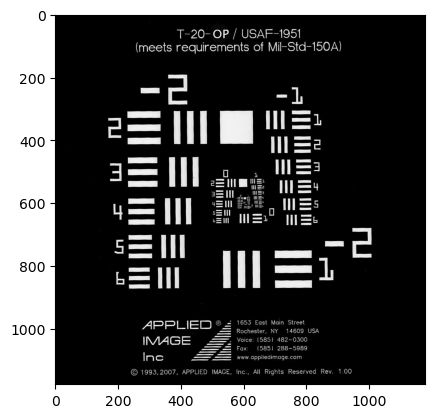

In [5]:
plt.imshow(torch.sum(fpm_setup.objstack, dim =0), cmap = 'gray')

# simulate some measurements

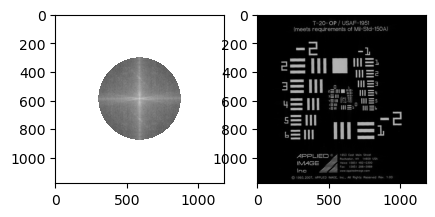

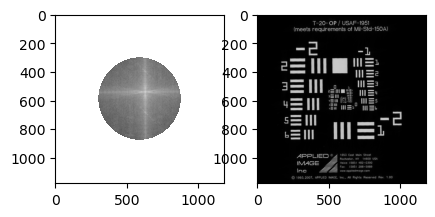

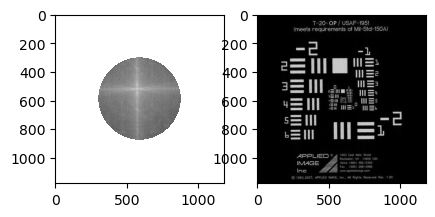

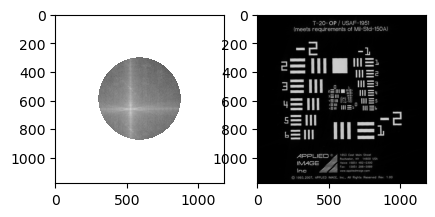

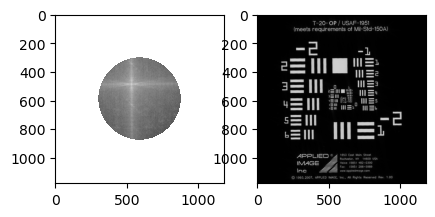

In [6]:
(measstack, list_leds) = fpm.createRandomAngleMeasStack(fpm_setup)

# Recon

In [ ]:
# obj_est = torch.zeros_like(obj,dtype = torch.float) # initializing to zeros doesn't work well. 
# obj_est = measstack[0,:,:] # initialize to first measurement instead
init_spectrum = torch.ones([fpm_setup.Nw,1,1])  # create a spectrum vector with dimension (Nw, 1,1)
obj_est = measstack[0,:,:].unsqueeze(0).to(device)*init_spectrum.to(device)
obj_est.requires_grad = True
# regularizers
def hardthresh(x,val):
    return torch.maximum(x,torch.tensor(val))

# set hyperparameters
step_size = 1e1
num_iters = 100
num_meas = len(list_leds)
losses =[]
# move to gpu
if device.type == 'cuda':
    with torch.no_grad():
        obj_est = obj_est.to(device)
        fpm_setup.pupilstack = fpm_setup.pupilstack.to(device)
        measstack = measstack.to(device)
        obj_est.requires_grad = True
        

    # loop through measurement
for k2 in np.arange(num_meas): 
    # loop through iterations
    for k1 in np.arange(num_iters):
        # print(k1,k2)
        # get relevant actual measurement and move to gpu
        meas = measstack[k2,:,:]
        # loop through wavelength 
        # compute illumination angle from led indices
        led_ind = list_leds[k2]   
        led_pos = (led_ind[0]*led_spacing,led_ind[1]*led_spacing,d) # units = millimeters, (x,y,z)
        illum_angle = (np.arctan(led_pos[1]/led_pos[2]), np.arctan(led_pos[0]/led_pos[2]))

        # create stack of illum field
        illumstack = torch.zeros([Nw,Ny,Nx],dtype = torch.complex64).to(device)  # use complex dtype
        for k3 in np.arange(Nw):
            wv = wv_range[k3]
            illumstack[k3,:,:] = createIllumField(xygrid,illum_angle,wv)

        # simulate the forward measurement
        (yest, pup_obj) = forwardSFPM(obj_est,pupilstack, illumstack, Nw)

        # calculate error, aka loss, and backpropagate
        error = torch.norm(yest-meas)
        losses += [error.detach().cpu()]
        error.backward()
        # print(error)

        # update the object's reconstruction estimate based on error
        with torch.no_grad(): # need to do inplace operations inside this no_grad() function to retain as leaf variables. 
            # print(torch.norm(obj_est.grad))
            obj_est = obj_est - step_size*obj_est.grad # gradient update
            obj_est = hardthresh(obj_est,0) # proximal update

        # ensure the obj_est's grad flag is set correctly for next iteration to run properly
        obj_est.requires_grad = True


        if k1 == num_iters-1:
                try:
                    print(k2,k1)
                    plt.clf() # clear plot
                    plt.semilogy(losses)
                    display.display(plt.gcf()) # update single window
                    display.clear_output(wait=True) # update single window
                    # time.sleep(1)
                except KeyboardInterrupt:
                    break